In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [2]:
!ls

LICENSE		    env_norl.yml	  notebooks
README.md	    epsiode_plot.png	  prices_and_soc_over_episode.png
algo_comp_2019.png  examples		  reward_over_epsiode.png
algo_comp_2021.png  model_PPO_2019_5.zip  sustaingym
env.yml		    mypy.ini


In [3]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, StopTrainingOnNoModelImprovement
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv



from sustaingym.envs import ElectricityMarketEnv
from sustaingym.envs.battery.plot_utils import get_offline_optimal, setup_episode_plot, plot_episode, plot_model_training_reward_curves, plot_reward_distribution, plot_state_of_charge_and_prices, plot_reward_over_episode, run_model_for_evaluation
from sustaingym.envs.battery.wrapped import DiscreteActions

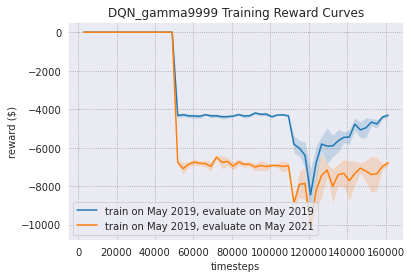

In [8]:
ax = plot_model_training_reward_curves(None, 'DQN_gamma9999', ['in_dist', 'out_dist'])

# plt.savefig('examples/logs_PPO/ppo_reward_curves.png', dpi=300)

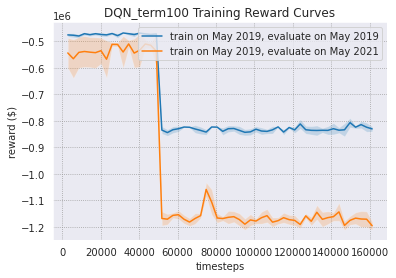

In [9]:
ax = plot_model_training_reward_curves(None, 'DQN_term100', ['in_dist', 'out_dist'])

# plt.savefig('examples/logs_A2C/a2c_reward_curves.png', dpi=300)

In [ ]:
env_2019 = ElectricityMarketEnv(month='2019-05', seed=195)

ppo = PPO.load('examples/model_PPO_2019_5.zip')
dqn = A2C.load('examples/discrete_model_DQN_2019_5.zip')

ax = plot_reward_distribution(None, env_2019, [ppo, dqn],
    ['ppo in dist', 'dqn out dist'], 10, '2019')

plt.xticks(rotation=30)

plt.savefig('algo_comp_2019.png', dpi=300)



In [ ]:
env_2021 = ElectricityMarketEnv(month='2021-05', seed=215)

ppo = PPO.load('examples/model_PPO_2019_5.zip')
dqn = A2C.load('examples/discrete_model_DQN_2019_5.zip')

ax = plot_reward_distribution(None, env_2021, [ppo, dqn],
    ['ppo out dist', 'dqn out dist'], 10, '2021')

plt.savefig('algo_comp_2021.png', dpi=300)

In [ ]:
import datetime
import gym
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

# class DiscreteActions(gym.ActionWrapper):
#     def __init__(self, env: ElectricityMarketEnv):
#         super().__init__(env)
#         self.env = env
#         self.charge_action = (env.action_space.high[0], env.action_space.high[0])
#         self.discharge_action = (0.01*env.action_space.high[0], 0.01*env.action_space.high[0])
#         self.action_space = gym.spaces.Discrete(2)
    
#     def action(self, action: int):
#         assert action in [0, 1]
#         if action == 0:
#             return self.charge_action
#         else:
#             return self.discharge_action
    
#     def _calculate_prices_without_agent(self) -> np.ndarray:
#         return self.env._calculate_prices_without_agent()
    
#     def _calculate_price_taking_optimal(
#             self, prices: np.ndarray, init_charge: float,
#             final_charge: float) -> tuple[float, np.ndarray]:
#         return self.env._calculate_price_taking_optimal(prices, init_charge, final_charge)
    
#     def _calculate_terminal_cost(self, agent_battery_charge: float) -> float:
#         return self.env._caculate_terminal_cost(agent_battery_charge)

df_load = pd.read_csv('sustaingym/data/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

env = ElectricityMarketEnv(month='2019-05', seed=195)
discrete_env = DiscreteActions(env)

a2c = A2C.load('examples/discrete_model_A2C_2019_5.zip')

ax, ax2 = plot_state_of_charge_and_prices(None, df_load, a2c, 'a2c in-dist', discrete_env)

plt.savefig('prices_and_soc_over_episode.png', dpi=300)

In [ ]:
env = ElectricityMarketEnv(month='2019-05', seed=195)
env = DiscreteActions(env)
ppo = PPO.load('examples/discrete_model_PPO_2019_5.zip')

ax, ax2 = plot_reward_over_episode(None, ppo, env)

plt.savefig('reward_over_epsiode.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


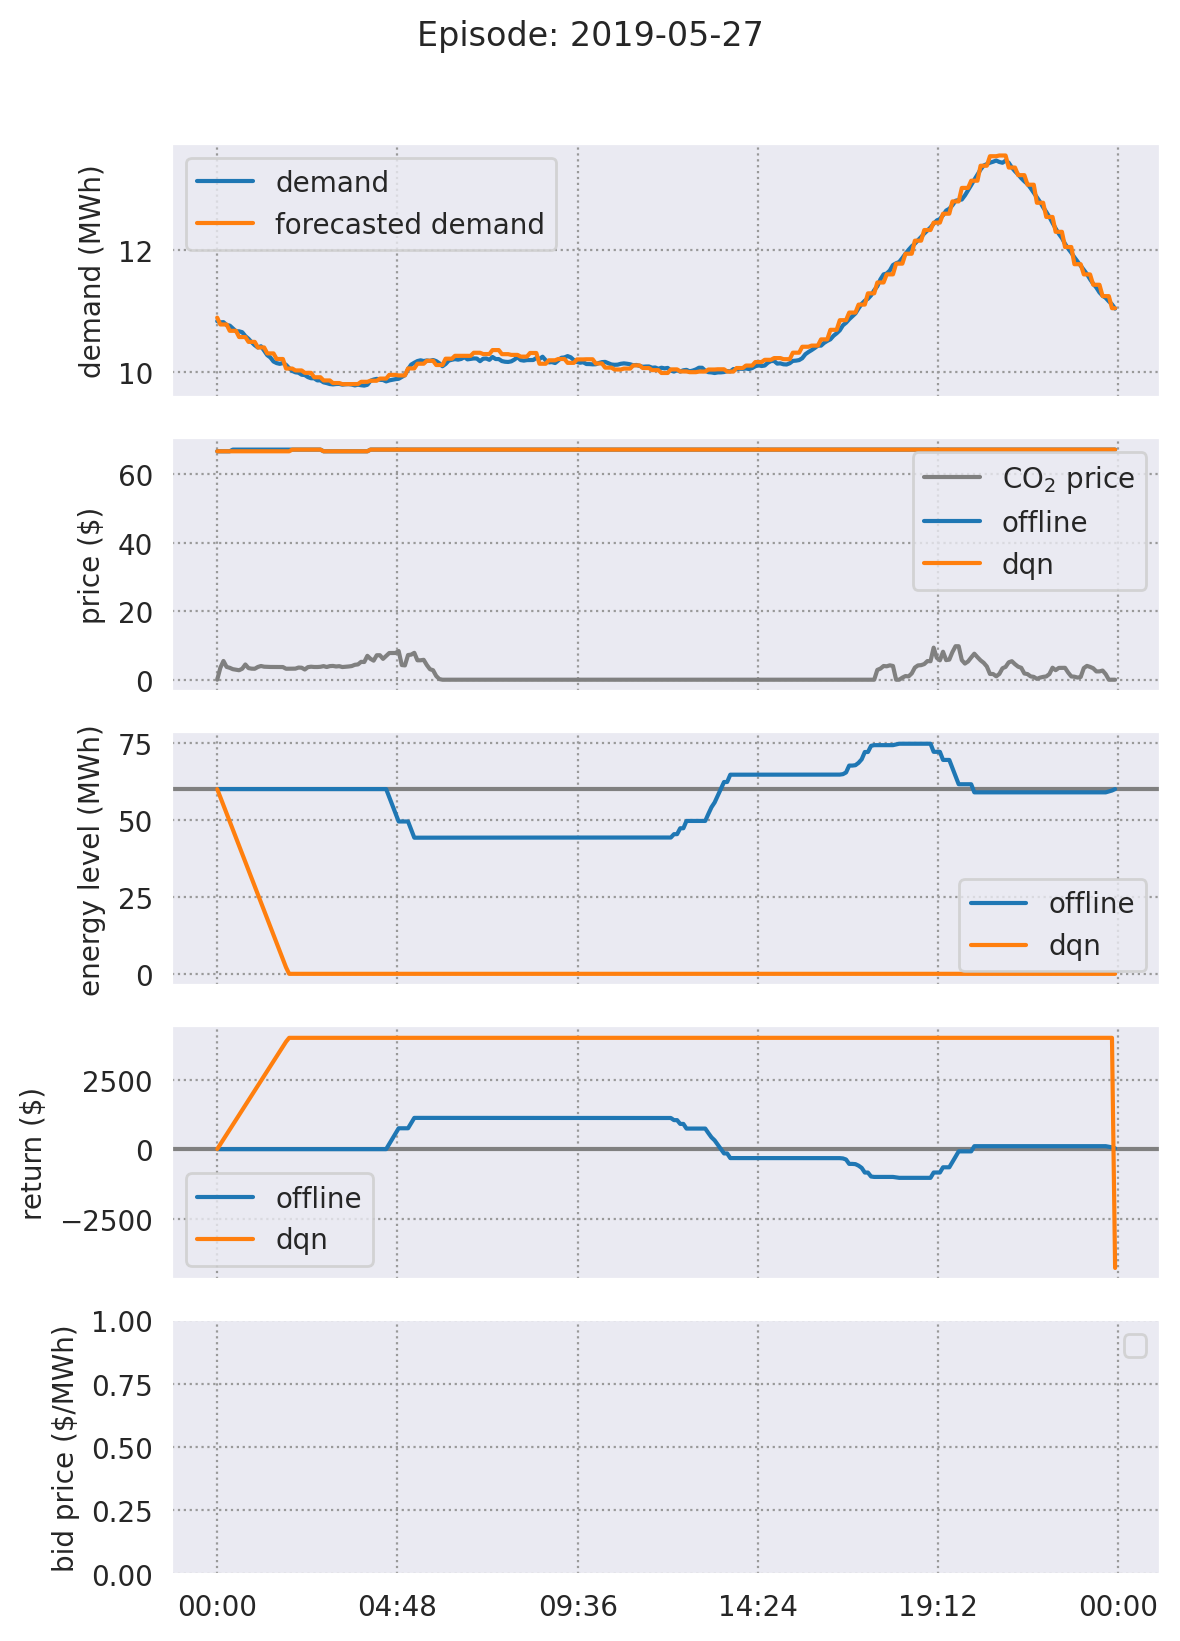

In [6]:
env = ElectricityMarketEnv(month='2019-05', seed=195)

# run offline optimal
env.reset(seed=10)
off_rewards, off_prices, net_prices, off_energy, dispatch = get_offline_optimal(seeds=[0], env=env)
dispatch = dispatch[0]
offline_data = {
    'rewards': off_rewards[0],
    'prices': off_prices[0],
    'model_name': 'offline',
    'energy_level': off_energy[0]
}
# print('offline return:', np.sum(rewards[0]))

# max_price = env.action_space.high[0]
# charge_action = (max_price, max_price)
# discharge_action = (0.01*max_price, 0.01*max_price)
# no_action = (0, max_price)

# prices = np.zeros(env.MAX_STEPS_PER_EPISODE)
# energy = np.zeros(env.MAX_STEPS_PER_EPISODE)
# rewards = np.zeros(env.MAX_STEPS_PER_EPISODE)
# obs, info = env.reset(seed=0, return_info=True)
# energy[0] = obs['energy'][0]

# for i in range(287):
#     action = no_action
#     if (dispatch[i] < -0.1) and (energy[i] < offline_data['energy_level'][i+1]):
#         action = charge_action
#     elif (dispatch[i] > 0.1) and (energy[i] > offline_data['energy_level'][i+1]):
#         action = discharge_action
#     obs, reward, _, info = env.step(action)
#     rewards[i+1] = reward
#     energy[i+1] = obs['energy'][0]
#     prices[i+1] = info['price']
# prices[0] = prices[1]

# follow_offline_data = {
#     'rewards': rewards,
#     'prices': prices,
#     'model_name': 'follow_offline',
#     'energy_level': energy
# }

# run PPO model
env.reset(seed=10)
ppo = PPO.load('examples/model_PPO_2019_5.zip')
ppo_rewards, ppo_prices, ppo_energy, ppo_bids = run_model_for_evaluation(ppo, 1, env, True, True, False, True)

ppo_data = {
    'rewards': ppo_rewards[0],
    'prices': ppo_prices[0],
    'model_name': 'ppo',
    'energy_level': ppo_energy[0],
    'bids': ppo_bids[0]
}

# run DQN model
env.reset(seed=10)
dqn = DQN.load('examples/discrete_model_DQN_gamma9999_2019_5.zip')
dqn_rewards, dqn_prices, dqn_energy = run_model_for_evaluation(ppo, 1, env, True, True, False, False)

dqn_data = {
    'rewards': dqn_rewards[0],
    'prices': dqn_prices[0],
    'model_name': 'dqn',
    'energy_level': dqn_energy[0]
}

fig, axs, times = setup_episode_plot(env, '2019-05', include_bids=True)
plot_episode(axs, times, **offline_data)
# plot_episode(axs, times, **ppo_data)
plot_episode(axs, times, **dqn_data)
# plot_episode(axs, times, **follow_offline_data)

for ax in axs:
    ax.legend()

plt.savefig('epsiode_plot.png', dpi=300)